# Load

In [2]:

from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd


abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': 'data\sheng2022.shp',
    'World_shp':'data\main_ADM_0.shp',
    'rsds':r'D:\xarray\aligned2\rsds\*.nc',
    'tas':r'D:\xarray\aligned2\tas\*.nc',
    'wind':r'D:\xarray\aligned2\wind\*.nc'
}

YEARS = [2018, 2020]
time=['2018-01-01','2020-01-01']
# 2. 读取 PV 站点并切片（测试模式）
# 2. 读取 PV 站点并切片（测试模式）
# pv_df = load_pv_sites(PATHS['csv'], years=YEARS)
# # Convert lon and lat columns to float32

# pv_df['lon'] = pv_df['lon'].astype('float32')
# pv_df['lat'] = pv_df['lat'].astype('float32')
# # Rename 'year' to 'time' and convert to datetime64
# pv_df = pv_df.rename(columns={'year': 'time'})
# pv_df['time'] = pd.to_datetime(pv_df['time'], format='%Y')




# 1. 打开并 rechunk
ds_abandon, ds_feat = load_datasets(
    PATHS['abandonment'], PATHS['feature']
)

import xarray as xr

ds_merge=xr.merge([ds_abandon, ds_feat])
# Convert coordinates to float32 while preserving other variables
ds_merge = ds_merge.assign_coords({
    'lon': ds_merge.lon.astype('float32'),
    'lat': ds_merge.lat.astype('float32')
})

# For variables without time dimension, expand them to have same value for all times
for var in ds_merge.data_vars:
    if 'time' not in ds_merge[var].dims:
        # Expand the variable to have time dimension with same values
        ds_merge[var] = ds_merge[var].expand_dims(time=ds_merge.time)

        
ds_merge

# 加载矢量数据

# Read the shapefile
# gdf = gpd.read_file(PATHS['CN_sheng'])
# zj_bound = gdf[gdf['省']=='浙江省']
# zj_bound = zj_bound.to_crs(ds_merge.rio.crs)

gdf = gpd.read_file(PATHS['World_shp'])
us_bound = gdf[gdf['GID_0']=='USA']
us_extent = us_bound.total_bounds  # Returns (minx, miny, maxx, maxy)
us_bound = us_bound.to_crs(ds_merge.rio.crs)



c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\anacon

## 美国研究区定义

In [3]:

# 定义美国研究区

try:
    # 定义东西两部分的边界
    usa_bounds_main = {
        'lon_min': -125,  # 美国本土最西端（华盛顿州）
        'lon_max': -65,   # 美国本土最东端（缅因州）
        'lat_min': 25,    # 美国本土最南端（佛罗里达州）
        'lat_max': 49     # 美国本土最北端（与加拿大接壤）
    }

    usa_bounds_west = {
        'lon_min': 170,   # 阿拉斯加最西端
        'lon_max': 180,   # 日界线西侧
        'lat_min': 18,    # 夏威夷最南端
        'lat_max': 72     # 阿拉斯加最北端
    }

    # 获取东西两部分的mask
    # 创建mask - 选择2020年废弃的栅格
    abandonment_year = ds_merge['abandonment_year'].sel(
        time='2020-01-01'
        # lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
        # lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
    )
    
    abandonment_duration = ds_merge['abandonment_duration'].sel(
        time='2020-01-01' 
        # lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
        # lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
    )
    
    mask_main = ((abandonment_year + abandonment_duration - 1) >= 2020) | (ds_merge['recultivation'].sel(time='2020-01-01') == 1)

except:
    None
# Calculate validation number
valid_count = mask_main.values.sum()  # 使用.values转换为numpy数组并计算和
 # Changed notna() to notnull() since it's the correct xarray method
print(f"Number of valid abandonment years: {valid_count}")


Number of valid abandonment years: 1984684


In [6]:
df_test = ds_merge['abandonment_year'].sel(time=['2020-01-01']).where(mask_main)
print("Total count of values in df_test:", df_test.count().compute())

Total count of values in df_test: <xarray.DataArray 'abandonment_year' ()> Size: 4B
array(1984684)
Coordinates:
    spatial_ref  int32 4B 0
    band         int32 4B 1


# Get data

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import os
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import gc

def combine_feature(ds_merge, filename , timeflag, step, stop=1,write_csv=False,out_path=None):

    #step = 500
    total_lat = len(ds_merge.lat)
    total_lon = len(ds_merge.lon)
    merged_dfs = []

    if write_csv:
        # 如果已存在，则先删，让 header 只写一次
        if os.path.exists(out_path):
            os.remove(out_path)
        first = True
    
    
    # Calculate total iterations for progress bar
    total_iterations = (total_lat // step + (1 if total_lat % step else 0)) * \
                    (total_lon // step + (1 if total_lon % step else 0))

    # Create progress bar with Chinese description
    pbar = tqdm(total=total_iterations, desc="处理数据块")

    # Iterate through all latitude and longitude points in chunks
    for start_lat in range(0, total_lat, step):
        end_lat = min(start_lat + step, total_lat)
        for start_lon in range(0, total_lon, step):
            end_lon = min(start_lon + step, total_lon)
            #print(1)
            # Extract data from ds_merge for each time point
            df = ds_merge.isel(
                lat=slice(start_lat, end_lat),
                lon=slice(start_lon, end_lon)
            ).compute()
            
            # Reset index to convert multi-index to columns
            df = df.to_dataframe(name=ds_merge.name).reset_index()

            mask_df = (
                computed_mask
                .isel(lat=slice(start_lat, end_lat), lon=slice(start_lon, end_lon))
                .to_dataframe(name="mask_main")
                .reset_index()[["lat", "lon", "mask_main"]]
            )

            df = df.merge(mask_df, on=["lat","lon"], how="inner")
            df = df[df["mask_main"]].drop(columns="mask_main")

            if write_csv:
                # —— 4a) 流式写 CSV ——#
                if not df.empty:
                    df.to_csv(
                        out_path, 
                        index=False, 
                        header=first, 
                        mode="w" if first else "a"
                    )
                    first = False
            else:
                # —— 4b) 收集 DF ——#
                if not df.empty:
                    merged_dfs.append(df)

            pbar.update(1)
            if stop == 1:
                break
    # Close progress bar
    pbar.close()
    gc.collect()

    if not write_csv:
        merged_df = pd.concat(merged_dfs, ignore_index=True)
        merged_df.to_csv(out_path, index=False)  
        return merged_df
    else:
        # 写 CSV 分支不返回大 DF
        print(f"已写入：{out_path}")
        return None


abandonment_year = ds_merge['abandonment_year'].sel(
        time='2020-01-01'
        lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
        lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
    )
    
abandonment_duration = ds_merge['abandonment_duration'].sel(
    time='2020-01-01' 
    lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
    lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
)

mask_main = ((abandonment_year + abandonment_duration - 1) >= 2020) | (ds_merge['recultivation'].sel(time='2020-01-01') == 1)

computed_mask = mask_main.compute()

all_vars = list(ds_merge.data_vars)
merged_dfs = []
timeflag=2020
# Iterate through each variable
for i, var in enumerate(all_vars):
    print(f"Processing variable {i+1} of {len(all_vars)}: {var}")
    
    # Filter for region and time, and apply mask
    df_temp = ds_merge[var].sel(
        time=pd.Timestamp('2020-01-01'),
        lat=slice(usa_bounds_main['lat_min'], usa_bounds_main['lat_max']),
        lon=slice(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
    ).where(computed_mask)
    # # Check if output file already exists for this variable
    # mergedf_path = os.path.join('D:\\xarray\\03_test', f'Global_abandonment_{var}_{timeflag}.csv')
    # if os.path.exists(mergedf_path):
    #     print(f"Skipping {var} - output file already exists")
    #     continue
    merged_df = combine_feature(df_temp, filename=var, timeflag=2020, step=2500, stop=0,write_csv=False,out_path=mergedf_path)
    merged_dfs.append(merged_df)


# final_merged_df = merged_dfs[0]
# for df in tqdm(merged_dfs[1:], desc="合并数据"):

#     final_merged_df = pd.merge(
#         final_merged_df,
#         df,
#         on=["time", "lon", "lat"],
#         how="inner",
#         suffixes=("", "_drop")
#     )
#     # Drop duplicated columns with "_drop" suffix
#     final_merged_df = final_merged_df.loc[:, ~final_merged_df.columns.str.endswith("_drop")]

# final_merged_df
#df_dem=combine_feature(pv_df, ds_merge.DEM.sel(time=['2018-01-01','2020-01-01']),step=2500,stop=1)
#ds_merge.gdmp.sel(time=['2018-01-01','2020-01-01'])
#df_gdmp=combine_feature(pv_df, ds_merge.gdmp.sel(time=['2018-01-01','2020-01-01']),step=2500,stop=1)


Processing variable 1 of 20: abandonment_year


处理数据块: 100%|██████████| 162/162 [07:51<00:00,  2.91s/it]


Processing variable 2 of 20: abandonment_duration


处理数据块: 100%|██████████| 162/162 [08:29<00:00,  3.15s/it]


Processing variable 3 of 20: recultivation


处理数据块: 100%|██████████| 162/162 [09:25<00:00,  3.49s/it]


Processing variable 4 of 20: current_abandonment


处理数据块: 100%|██████████| 162/162 [09:36<00:00,  3.56s/it]


Processing variable 5 of 20: landcover


处理数据块: 100%|██████████| 162/162 [14:05<00:00,  5.22s/it]


Processing variable 6 of 20: DEM


处理数据块: 100%|██████████| 162/162 [08:53<00:00,  3.29s/it]


Processing variable 7 of 20: gdmp


处理数据块: 100%|██████████| 162/162 [10:48<00:00,  4.01s/it]


Processing variable 8 of 20: GDPpc


处理数据块: 100%|██████████| 162/162 [10:15<00:00,  3.80s/it]


Processing variable 9 of 20: GDPtot


处理数据块: 100%|██████████| 162/162 [10:35<00:00,  3.92s/it]


Processing variable 10 of 20: GURdist


处理数据块: 100%|██████████| 162/162 [09:18<00:00,  3.45s/it]


Processing variable 11 of 20: landcover_at_abandonment


处理数据块: 100%|██████████| 162/162 [08:27<00:00,  3.13s/it]


Processing variable 12 of 20: Population


处理数据块: 100%|██████████| 162/162 [10:35<00:00,  3.92s/it]


Processing variable 13 of 20: Powerdist


处理数据块: 100%|██████████| 162/162 [08:16<00:00,  3.06s/it]


Processing variable 14 of 20: PrimaryRoad


处理数据块: 100%|██████████| 162/162 [09:08<00:00,  3.38s/it]


Processing variable 15 of 20: rsds


处理数据块: 100%|██████████| 162/162 [10:36<00:00,  3.93s/it]


Processing variable 16 of 20: SecondaryRoad


处理数据块: 100%|██████████| 162/162 [09:19<00:00,  3.45s/it]


Processing variable 17 of 20: Slope


处理数据块: 100%|██████████| 162/162 [08:47<00:00,  3.26s/it]


Processing variable 18 of 20: tas


处理数据块: 100%|██████████| 162/162 [11:48<00:00,  4.37s/it]


Processing variable 19 of 20: TertiaryRoad


处理数据块: 100%|██████████| 162/162 [09:57<00:00,  3.69s/it]


Processing variable 20 of 20: wind


处理数据块: 100%|██████████| 162/162 [10:14<00:00,  3.79s/it]


In [9]:
final_merged_df = merged_dfs[0]
for df in tqdm(merged_dfs[1:], desc="合并数据"):

    final_merged_df = pd.merge(
        final_merged_df,
        df,
        on=["time", "lon", "lat"],
        how="inner",
        suffixes=("", "_drop")
    )
    # Drop duplicated columns with "_drop" suffix
    final_merged_df = final_merged_df.loc[:, ~final_merged_df.columns.str.endswith("_drop")]
    final_merged_df.to_csv(r"D:\xarray\03_test\Global_total_2020.csv", index=False)

合并数据: 100%|██████████| 19/19 [09:07<00:00, 28.81s/it]


: 

In [47]:
final_merged_df

,time,lat,lon,spatial_ref,band,abandonment_year,abandonment_duration,recultivation,current_abandonment,landcover,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
0,2020-01-01,25.004168,-124.995834,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,25.004168,-124.987503,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,25.004168,-124.979164,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,25.004168,-124.970833,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,25.004168,-124.962502,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20735995,2020-01-01,48.995834,-65.037498,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20735996,2020-01-01,48.995834,-65.029167,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20735997,2020-01-01,48.995834,-65.020836,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20735998,2020-01-01,48.995834,-65.012497,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Count values where abandonment_year is True (1.0)
true_count = final_merged_df['current_abandonment'].eq(1).sum()
print(f"Number of locations with abandonment (value=1.0): {true_count}")

final_merged_df

Number of locations with abandonment (value=1.0): 79021


,time,lat,lon,spatial_ref,band,abandonment_year,abandonment_duration,recultivation,current_abandonment,landcover,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
0,2020-01-01,25.004168,-124.995834,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,25.004168,-124.987503,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,25.004168,-124.979164,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,25.004168,-124.970833,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,25.004168,-124.962502,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20735995,2020-01-01,48.995834,-65.037498,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20735996,2020-01-01,48.995834,-65.029167,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20735997,2020-01-01,48.995834,-65.020836,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20735998,2020-01-01,48.995834,-65.012497,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Save final merged dataframe to CSV

final_merged_df.drop(['spatial_ref', 'band'], axis=1).to_csv('data/us_abandoen.csv', index=False)

Total number of wind values in df_temp: 20736000 (1 time x 2880 lat x 7200 lon = 20736000)


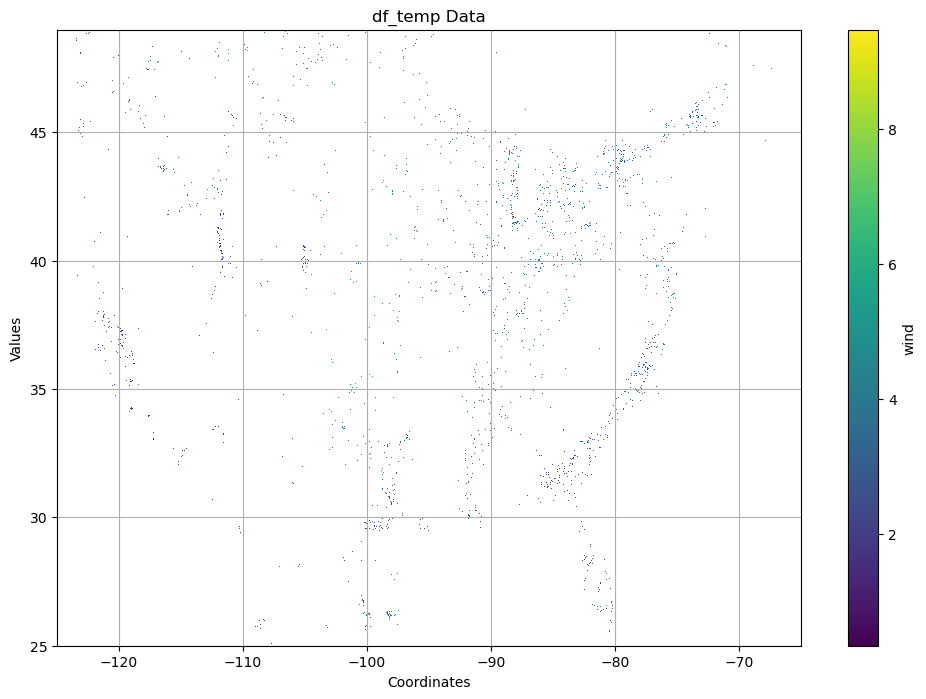

In [11]:
# Plot df_temp using matplotlib
import matplotlib.pyplot as plt
# Count and print number of valid (non-NaN) values in df_temp
valid_count = df_temp['wind'].notnull().sum().sum()
print(f"Number of valid wind values in df_temp: {valid_count}")


plt.figure(figsize=(12, 8))
df_temp.plot()
plt.title('df_temp Data')
plt.xlabel('Coordinates')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [8]:
merged_dfs

[]

纬度：32.5° 到 42.0°（差9.5°）
经度：-124.4° 到 -114.1°（差10.3°）
分辨率：0.0083°
理论格点数：
纬向：9.5° / 0.0083° ≈ 1145点
经向：10.3° / 0.0083° ≈ 1241点

142万差不多

In [9]:

# # Concatenate all merged dataframes with single-column retention
# Read first CSV file
csv_paths = [f'D:\\xarray\\03_training_data\\merged_df_{var}_2020.csv' for var in all_vars]
final_merged_df = pd.read_csv(csv_paths[0])

# Merge remaining CSV files
for csv_path in tqdm(csv_paths[1:], desc="合并数据"):
    df = pd.read_csv(csv_path)
    final_merged_df = pd.merge(
        final_merged_df,
        df,
        on=["time", "lon", "lat"], 
        how="inner",
        suffixes=("", "_drop")
    )
    final_merged_df = final_merged_df.loc[:, ~final_merged_df.columns.str.endswith("_drop")]

合并数据:   0%|          | 0/18 [00:00<?, ?it/s]

In [10]:
final_merged_df

,time,lat,lon,band,spatial_ref,abandonment_year,abandonment_duration,recultivation,current_abandonment,landcover,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
0,2020-01-01,27.045834,118.02917,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,27.045834,118.03750,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,27.045834,118.04583,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,27.045834,118.05417,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,27.045834,118.06250,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293225,2020-01-01,31.179167,122.90417,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293226,2020-01-01,31.179167,122.91250,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293227,2020-01-01,31.179167,122.92083,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293228,2020-01-01,31.179167,122.92917,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
from function import *  
import geopandas as gpd
from shapely.geometry import Point
def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')
    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped
global_df = pd.read_csv(r'D:\xarray\03_test\Global_total_2020.csv')

usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)
df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值


In [3]:
df_abandon_filtered

,lat,lon,time,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,gdmp,GDPpc,...,landcover_at_abandonment,Population,Powerdist,PrimaryRoad,rsds,SecondaryRoad,Slope,tas,TertiaryRoad,wind
0,21.895834,-159.47084,2020-01-01,2013.0,10.0,1,2.0,51.2500,117.119888,41938.0,...,NaN,402.430940,3.292825e+06,0.000000,20.518538,0.000000,2.791620,2975.645809,0.000000,4.574830
1,21.904167,-159.57916,2020-01-01,2014.0,9.0,1,2.0,32.7500,37.481422,41938.0,...,NaN,484.819730,3.291227e+06,0.000000,20.408428,0.000000,2.495157,2978.889888,0.000000,4.228809
2,21.904167,-159.52083,2020-01-01,2011.0,12.0,1,2.0,138.5000,160.905777,41938.0,...,NaN,569.599550,3.291664e+06,0.000000,20.648110,0.000000,4.957572,2971.540692,0.000000,4.864865
3,21.904167,-159.46250,2020-01-01,2010.0,13.0,1,4.0,67.6875,144.940460,41938.0,...,NaN,1405.485100,3.292111e+06,0.000000,20.446064,0.000000,0.546027,2974.577779,0.000000,4.176537
4,21.912500,-159.52083,2020-01-01,2010.0,13.0,1,2.0,204.3750,173.481995,41938.0,...,NaN,590.756800,3.290108e+06,0.000000,20.524061,0.000000,4.916435,2967.891430,0.000000,4.685113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71765,63.912500,-145.21250,2020-01-01,2009.0,14.0,1,2.0,359.8125,64.978180,51983.0,...,NaN,1.104929,7.807899e+02,5.781066,9.471990,0.000000,0.177922,2740.998586,37.049534,4.148036
71766,64.012500,-145.00417,2020-01-01,2010.0,13.0,1,2.0,335.2500,64.978180,51983.0,...,NaN,0.243558,9.369479e+03,0.000000,9.336362,0.000000,0.102241,2739.998586,14.365114,3.614530
71767,64.029170,-145.11250,2020-01-01,2018.0,5.0,1,2.0,331.8750,64.978180,51983.0,...,NaN,0.197275,9.369479e+03,0.000000,9.334987,0.000000,0.085302,2740.333333,14.133357,3.510094
71768,64.129166,-145.66250,2020-01-01,1998.0,25.0,1,2.0,317.8125,64.978180,51983.0,...,NaN,24.505394,7.807899e+02,0.000000,9.329527,3.136633,0.279026,2741.830566,70.305156,3.456614


In [7]:
import pandas


import numpy as np

# 只选择数值型变量
numeric_columns = df_abandon_filtered.select_dtypes(include=[np.number]).columns

# 分位数列表，从10到100每隔10
quantile_levels = np.arange(0.1, 1.01, 0.1)

for col in numeric_columns:
    quantiles = df_abandon_filtered[col].quantile(quantile_levels)
    print(f"{col} 变量的分位数：")
    for q, val in zip(quantile_levels, quantiles):
        print(f"  分位点 {int(q*100)}%: {val}")
    print("-" * 40)


lat 变量的分位数：
  分位点 10%: 30.545834
  分位点 20%: 32.679165
  分位点 30%: 35.0875
  分位点 40%: 37.295834
  分位点 50%: 39.2875
  分位点 60%: 40.4625
  分位点 70%: 41.754166
  分位点 80%: 43.095833
  分位点 90%: 45.270832
  分位点 100%: 64.82917
----------------------------------------
lon 变量的分位数：
  分位点 10%: -116.04583
  分位点 20%: -105.129166
  分位点 30%: -98.8125
  分位点 40%: -94.754166
  分位点 50%: -90.42917
  分位点 60%: -88.229164
  分位点 70%: -85.620834
  分位点 80%: -83.2125
  分位点 90%: -78.395836
  分位点 100%: -64.6625
----------------------------------------
abandonment_year 变量的分位数：
  分位点 10%: 1997.0
  分位点 20%: 1999.0
  分位点 30%: 2000.0
  分位点 40%: 2001.0
  分位点 50%: 2003.0
  分位点 60%: 2005.0
  分位点 70%: 2008.0
  分位点 80%: 2011.0
  分位点 90%: 2015.0
  分位点 100%: 2018.0
----------------------------------------
abandonment_duration 变量的分位数：
  分位点 10%: 8.0
  分位点 20%: 12.0
  分位点 30%: 15.0
  分位点 40%: 18.0
  分位点 50%: 20.0
  分位点 60%: 22.0
  分位点 70%: 23.0
  分位点 80%: 24.0
  分位点 90%: 26.0
  分位点 100%: 29.0
---------------------------------------